# 1. Problem Statement and Dataset Selection

Stroke is one of the leading causes of mortality and long-term disability worldwide.
Early identification of individuals at high risk can provide opportunities for preventive intervention and reduce the severity of stroke outcomes.

**Project Objective**

The goal of this project is to build a machine learning model that predicts whether a person is likely to experience a stroke based on demographic, lifestyle, and medical risk factors.

**Dataset**

*   Demographic attributes (age, gender, residence type)
*   Health indicators (BMI, glucose level, hypertension, heart disease)
*   Lifestyle factors (smoking status, work type)

The dataset is appropriate for supervised binary classification, since the target variable (stroke) contains two classes: 0 = no stroke, 1 = stroke

# 2. Data Preparation and Exploration

In [42]:
# 1. Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [43]:
# 2. Load dataset
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [44]:
# 3. Data Overview
df.info()
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


(5110, 12)

In [45]:
# 4. Handle missing values
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# 5. Remove irrelavant columns
df.drop('id', axis=1, inplace=True)

# 6. Encode Categorical Variables
df = pd.get_dummies(df, drop_first=True)
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,28.1,1,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,False,True,False


Stroke Incidence:

stroke
No Stroke    4861
Stroke        249
Name: count, dtype: int64


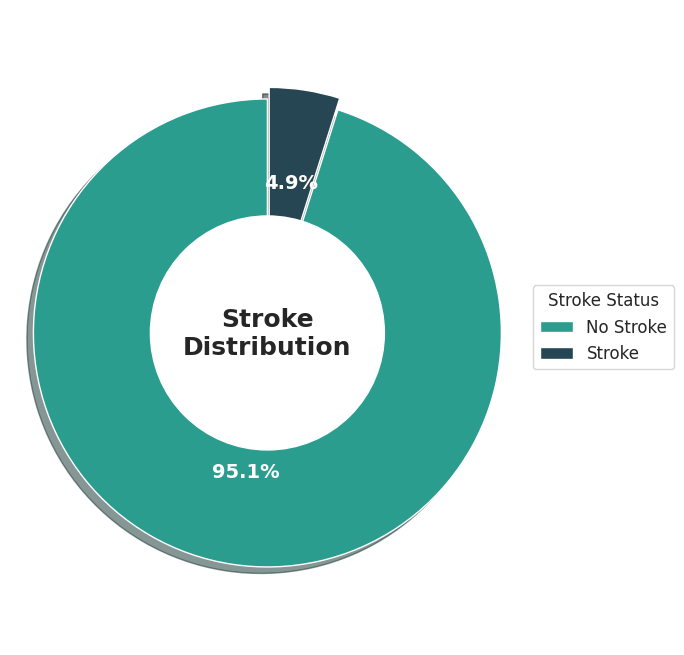

In [46]:
# 7. Class Distribution
stroke_labeled = df['stroke'].replace({0: 'No Stroke', 1: 'Stroke'})
stroke_counts = stroke_labeled.value_counts()
print("Stroke Incidence:\n")
print(stroke_counts)

plt.figure(figsize=(7,7))
explode = (0, 0.05)
wedges, texts, autotexts = plt.pie(
    stroke_counts,
    labels=stroke_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#2a9d8f', '#264653'],
    explode=explode,
    shadow=True,
    textprops={'fontsize': 14, 'weight': 'bold', 'color': 'white'}
)

centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.legend(wedges, stroke_counts.index,
           title="Stroke Status",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=12)

plt.text(0, 0, 'Stroke\nDistribution', horizontalalignment='center',
         verticalalignment='center', fontsize=18, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

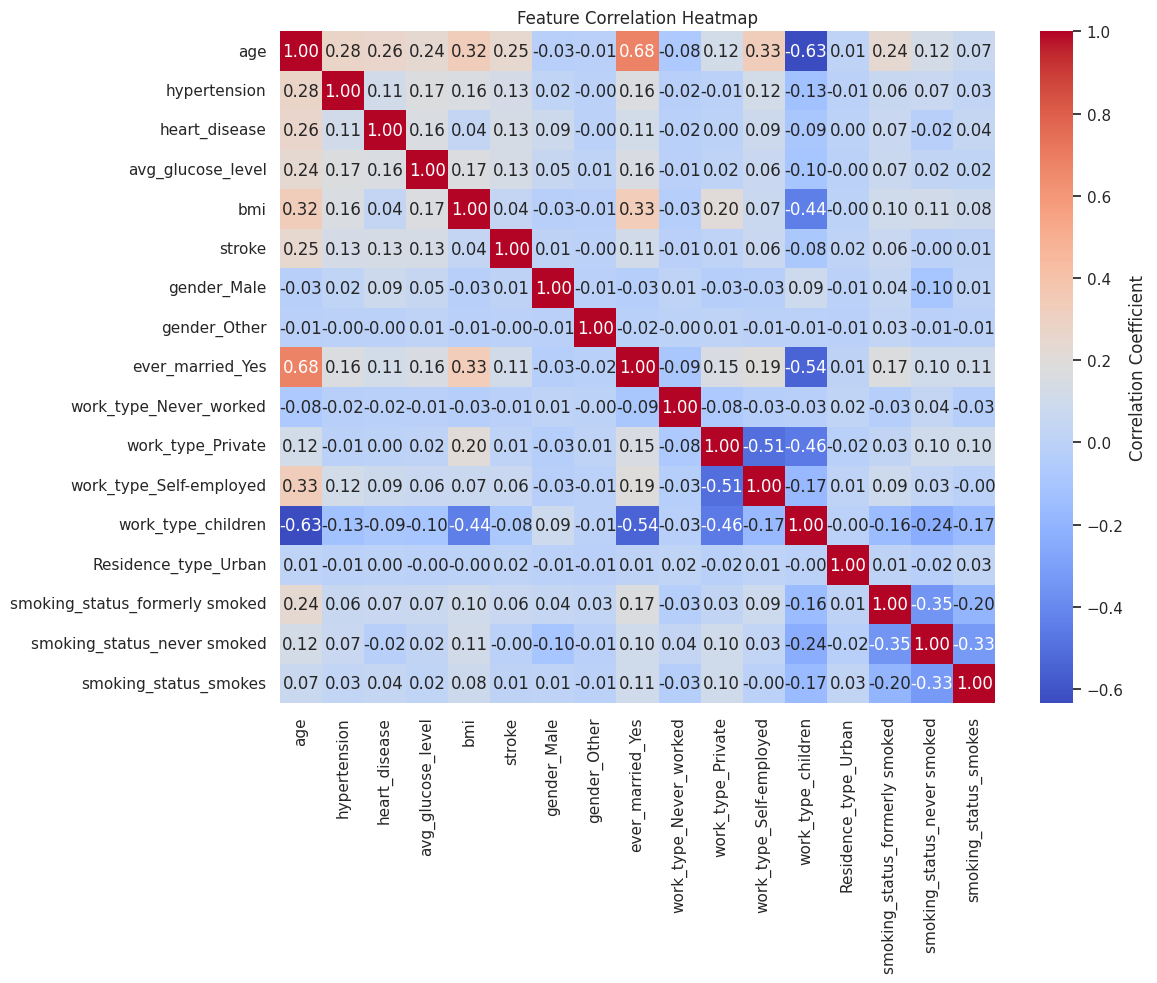

In [47]:
# 8. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# 3. Model Development and Evaluation

In [48]:
# Train-Test split
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [49]:
# Oversampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [50]:
pd.Series(y_train_resampled).value_counts()

,count
stroke,
0,3889
1,3889


In [51]:
# Scale numerical features
scaler = StandardScaler()
num_cols = ['age', 'bmi', 'avg_glucose_level']
X_train_resampled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [52]:
# Train models
# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_lr = log_reg.predict(X_test)

# 2. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt.predict(X_test)

# 3. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)

In [53]:
# Evaluation metrics
def evaluate_model(y_test, y_pred, model_name):
    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_dt, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")


=== Logistic Regression ===
Accuracy: 0.7446183953033269
ROC-AUC: 0.7708847736625515
[[721 251]
 [ 10  40]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.82      1022

=== Decision Tree ===
Accuracy: 0.923679060665362
ROC-AUC: 0.5804526748971193
[[934  38]
 [ 40  10]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.21      0.20      0.20        50

    accuracy                           0.92      1022
   macro avg       0.58      0.58      0.58      1022
weighted avg       0.92      0.92      0.92      1022

=== Random Forest ===
Accuracy: 0.9432485322896281
ROC-AUC: 0.5053703703703704
[[963   9]
 [ 49   1]]
              precision    recall  

In [54]:
# Model Tuning (Random Forest)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

evaluate_model(y_test, y_pred_best, "Tuned Random Forest")


=== Tuned Random Forest ===
Accuracy: 0.9432485322896281
ROC-AUC: 0.5148559670781894
[[962  10]
 [ 48   2]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.17      0.04      0.06        50

    accuracy                           0.94      1022
   macro avg       0.56      0.51      0.52      1022
weighted avg       0.91      0.94      0.93      1022



The tuned Random Forest model still produced very low recall and ROC-AUC (~0.50), confirming that tree-based methods are not effective for this dataset.

Accuracy is not reliable for imbalanced datasets because predicting the majority class only can still produce a high score.


Logistic Regression remained the best-performing model overall. It achieved the highest ROC-AUC and best recall for the minority class.

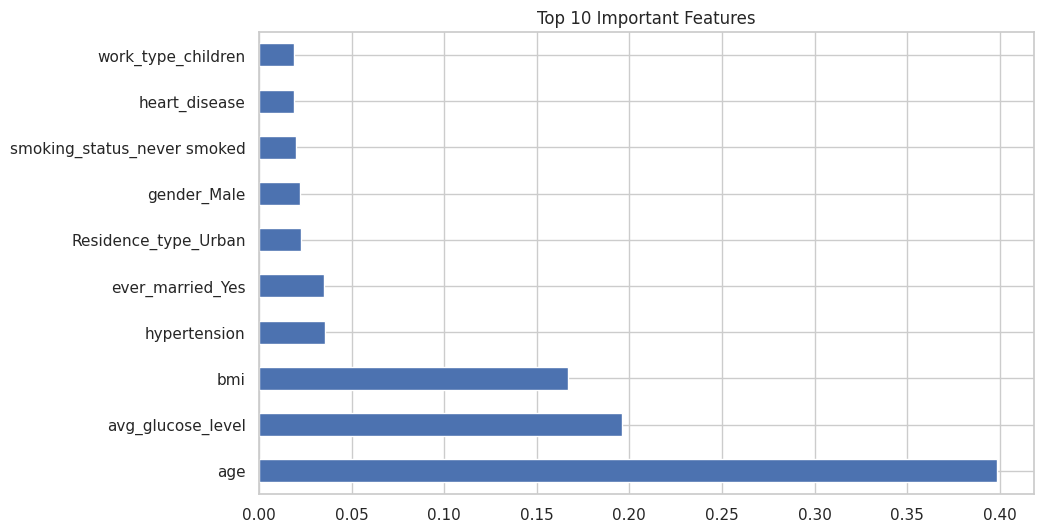

In [55]:
# Feature importance
feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()


## 4. Ethical Considerations and Conclusion

### Ethical Considerations
The dataset is highly imbalanced, which may cause models to ignore stroke cases and produce misleading accuracy scores. Oversampling was used to reduce this risk. Some variables (e.g., gender, residence type) may introduce bias, so fairness and interpretability should be considered when applying such models in healthcare.

### Conclusion
This project tested multiple models for stroke prediction. Logistic Regression performed best, achieving the highest ROC-AUC and the best detection of stroke cases. Tree-based models, even after tuning, struggled with the minority class. Future work may include applying cross-validation,collecting more detailed medical data, improving class balance, etc.
